In [117]:
#!pipenv install --skip-lock pmdarima
#!pipenv install --skip-lock matplotlib
#!pipenv install --skip-lock nb-black
# !pip install pmdarima
# !pip install nb-black

<IPython.core.display.Javascript object>

In [118]:
# check pmdarima
from pmdarima.arima import auto_arima
from statsmodels.tsa.seasonal import seasonal_decompose

<IPython.core.display.Javascript object>

### ARIMA

ARIMA (AutoRegressive Integrated Moving Average) is a forecasting algorithm based on the idea that the information in the past values of the time series can alone be used to predict the future values.

ARIMA models explain a time series based on its own past values, basically its own lags and the lagged forecast errors.

In [119]:
from IPython.core.debugger import set_trace

%load_ext nb_black

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import time

plt.style.use(style="seaborn")
%matplotlib inline

The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [120]:
df = pd.read_excel("bitcoin_master_data.xlsx")
df.head()

,Name,Symbol,Date,High,Low,Open,Close,market_billion_usd$,volume_billion_usd$,Day_Pct%_Change,Trend,Target,polarity,subjectivity
0,Bitcoin,BTC,2021-01-02,33155.11882,29091.18119,29376.45583,32127.26794,597,67.865421,9.372581,Bull run,1,0.086922,0.293221
1,Bitcoin,BTC,2021-01-03,34608.55674,32052.31708,32129.40736,32782.02447,609,78.665235,2.038009,Positive,1,0.067089,0.268607
2,Bitcoin,BTC,2021-01-04,33440.21857,28722.75527,32810.94764,31971.91352,594,81.163475,-2.471205,Negative,0,0.103779,0.302804
3,Bitcoin,BTC,2021-01-05,34437.59059,30221.18674,31977.04113,33992.42934,632,67.547325,6.319659,Among top gainers,1,0.080542,0.268689
4,Bitcoin,BTC,2021-01-06,36879.69857,33514.03374,34013.61453,36824.36441,685,75.289434,8.331076,Bull run,1,0.091530,0.317750


<IPython.core.display.Javascript object>

In [121]:
df.head(5)

,Name,Symbol,Date,High,Low,Open,Close,market_billion_usd$,volume_billion_usd$,Day_Pct%_Change,Trend,Target,polarity,subjectivity
0,Bitcoin,BTC,2021-01-02,33155.11882,29091.18119,29376.45583,32127.26794,597,67.865421,9.372581,Bull run,1,0.086922,0.293221
1,Bitcoin,BTC,2021-01-03,34608.55674,32052.31708,32129.40736,32782.02447,609,78.665235,2.038009,Positive,1,0.067089,0.268607
2,Bitcoin,BTC,2021-01-04,33440.21857,28722.75527,32810.94764,31971.91352,594,81.163475,-2.471205,Negative,0,0.103779,0.302804
3,Bitcoin,BTC,2021-01-05,34437.59059,30221.18674,31977.04113,33992.42934,632,67.547325,6.319659,Among top gainers,1,0.080542,0.268689
4,Bitcoin,BTC,2021-01-06,36879.69857,33514.03374,34013.61453,36824.36441,685,75.289434,8.331076,Bull run,1,0.091530,0.317750


<IPython.core.display.Javascript object>

In [122]:
df = df[["Close"]].copy()
df.columns = ["close"]
df.head()

,close
0,32127.26794
1,32782.02447
2,31971.91352
3,33992.42934
4,36824.36441


<IPython.core.display.Javascript object>

In [123]:
df.describe()

,close
count,186.000000
mean,45626.185145
std,10018.239126
min,30432.547080
25%,35809.052873
50%,46397.909275
75%,55939.859385
max,63503.457930


<IPython.core.display.Javascript object>

An ARIMA model is characterized by 3 terms (p, d, q):

- p is the order of the AR term

- d is the number of differencing required to make the time series stationary

- q is the order of the MA term

As we see in the parameters required by the model, any stationary time series can be modeled with ARIMA models.



### Stationarity

Subtract the previous value from the current value. Now if we just difference once, we might not get a stationary series so we might need to do that multiple times. 

And the minimum number of differencing operations needed to make the series stationary needs to be imputed into our ARIMA model. 

Stationarity check is important in time series as we need to check what mathematical operations on the series
make it predictable for future. For stationary time series the mean and variance is constant, 
so it is more predictable compared to non stationary time series. 
One of the test for stationarity is Augmented Dickey Fuller Test (ADF for short)
Wiki link: https://en.wikipedia.org/wiki/Augmented_Dickey%E2%80%93Fuller_test
Critical values for Dickey–Fuller t-distribution. 


#### ADF test

We'll use the Augumented Dickey Fuller (ADF) test to check if the price series is stationary.

The null hypothesis of the ADF test is that the time series is non-stationary. So, if the p-value of the test is less than the significance level (0.05) then we can reject the null hypothesis and infer that the time series is indeed stationary.

So, in our case, if the p-value > 0.05 we'll need to find the order of differencing.

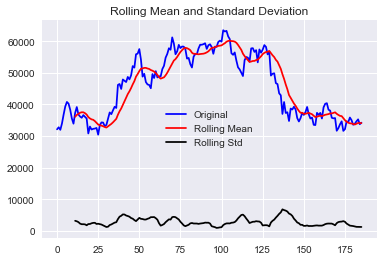

Results of Dickey Fuller test
Test Statistics                 -1.144221
p-value                          0.697119
No. of lags used                12.000000
Number of observations used    173.000000
critical value (1%)             -3.468726
critical value (5%)             -2.878396
critical value (10%)            -2.575756
dtype: float64


<IPython.core.display.Javascript object>

In [124]:
# Test for stationarity
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()
    # Plot rolling statistics:
    plt.plot(timeseries, color="blue", label="Original")
    plt.plot(rolmean, color="red", label="Rolling Mean")
    plt.plot(rolstd, color="black", label="Rolling Std")
    plt.legend(loc="best")
    plt.title("Rolling Mean and Standard Deviation")
    plt.show(block=False)

    print("Results of Dickey Fuller test")
    adft = adfuller(timeseries, autolag="AIC")
    # output for dft will give us without defining what the values are.
    # hence we manually write what values does it explains using a for loop
    output = pd.Series(
        adft[0:4],
        index=[
            "Test Statistics",
            "p-value",
            "No. of lags used",
            "Number of observations used",
        ],
    )
    for key, values in adft[4].items():
        output["critical value (%s)" % key] = values
    print(output)


test_stationarity(df.close)

In [125]:
# Check if price series is stationary
from statsmodels.tsa.stattools import adfuller

result = adfuller(df.close.dropna())
print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")

ADF Statistic: -1.1442213133471415
p-value: 0.6971188287298822


<IPython.core.display.Javascript object>

# Based on the high p-value = 0.69 we observe that the time series is non stationary

# Check for seasonal decomposition

<ipython-input-126-c3fc738fefe0>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df.close, model="additive", freq=30)


<Figure size 432x288 with 0 Axes>

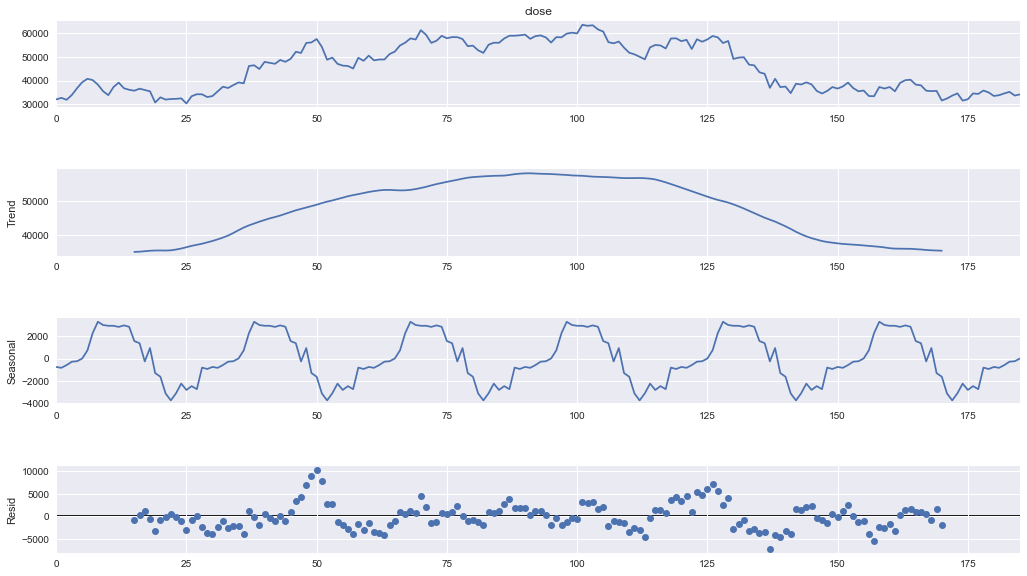

<IPython.core.display.Javascript object>

In [126]:
# additive
result = seasonal_decompose(df.close, model="additive", freq=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

<ipython-input-127-b76336541fcf>:2: FutureWarning: the 'freq'' keyword is deprecated, use 'period' instead
  result = seasonal_decompose(df.close, model="multiplicative", freq=30)


<Figure size 432x288 with 0 Axes>

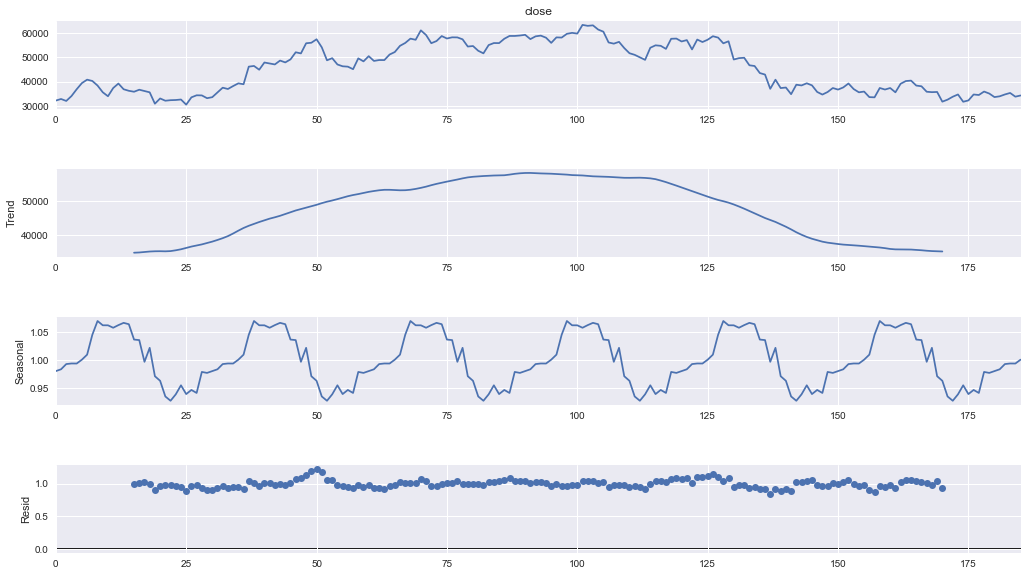

<IPython.core.display.Javascript object>

In [127]:
# multiplicative
result = seasonal_decompose(df.close, model="multiplicative", freq=30)
fig = plt.figure()
fig = result.plot()
fig.set_size_inches(16, 9)

#  Based on multiplicative model we see that the time series has a not quite long significant increasing or decreasing trend over months
#  as we can see that bitcoin prices were seems to be following an upward trend in starting 3months and then in last 3 months they seems to be showing decreasing trend.
#  While talking about seasonality,there seems to be seasonality present looking at seasonal component. 
#  Residual is mostly flat so most of the variance is explained by trend and seasonality.

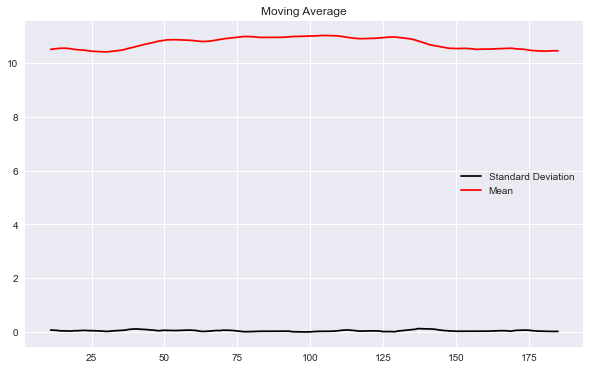

<IPython.core.display.Javascript object>

In [128]:
from pylab import rcParams

rcParams["figure.figsize"] = 10, 6
df_log = np.log(df.close)
moving_avg = df_log.rolling(12).mean()
std_dev = df_log.rolling(12).std()
plt.legend(loc="best")
plt.title("Moving Average")
plt.plot(std_dev, color="black", label="Standard Deviation")
plt.plot(moving_avg, color="red", label="Mean")
plt.legend()
plt.show()

#### Autocorrelation Function (ACF)

In [129]:
from statsmodels.graphics.tsaplots import plot_acf

<IPython.core.display.Javascript object>

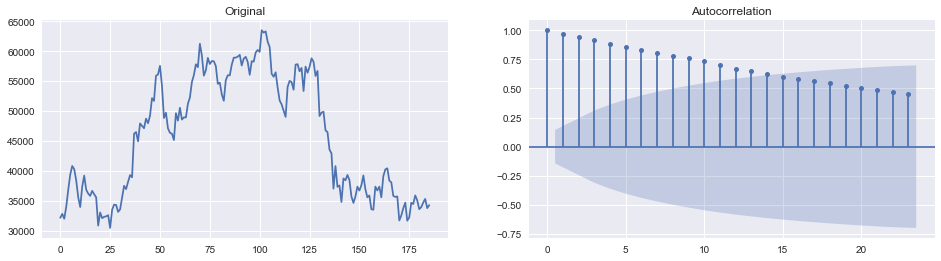

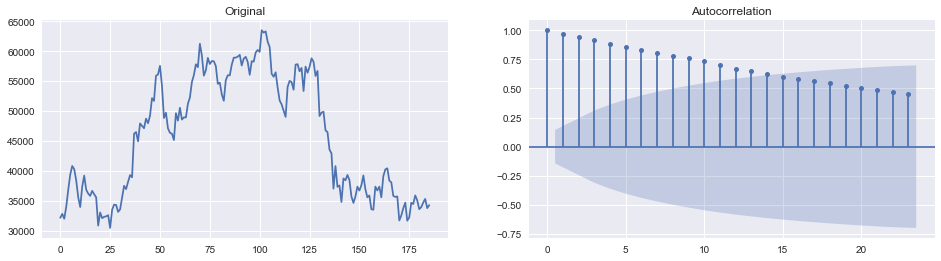

<IPython.core.display.Javascript object>

In [130]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(df.close)
ax1.set_title("Original")
# add ; at the end of the plot function so that the plot is not duplicated
plot_acf(df.close, ax=ax2)

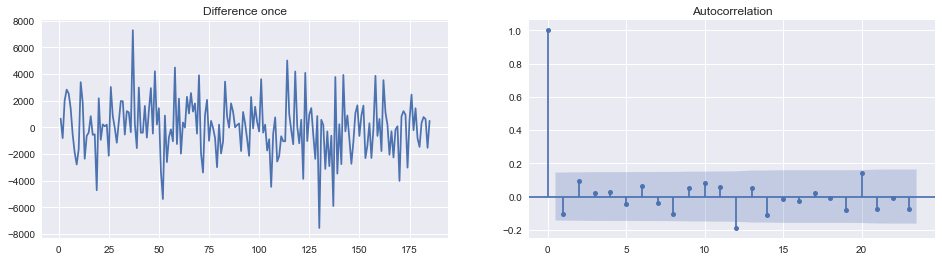

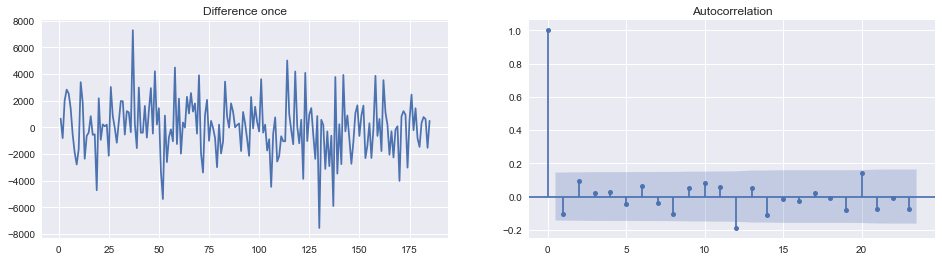

<IPython.core.display.Javascript object>

In [131]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
plot_acf(diff, ax=ax2)

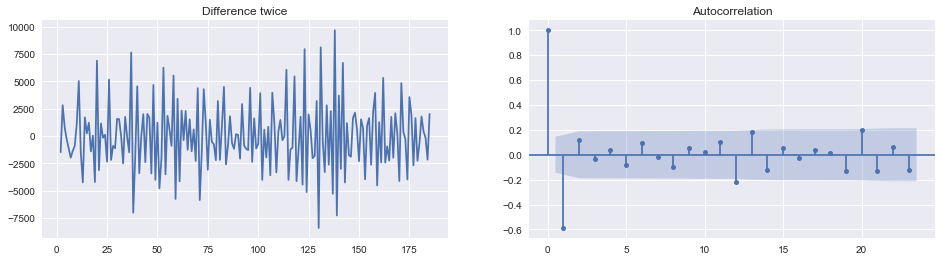

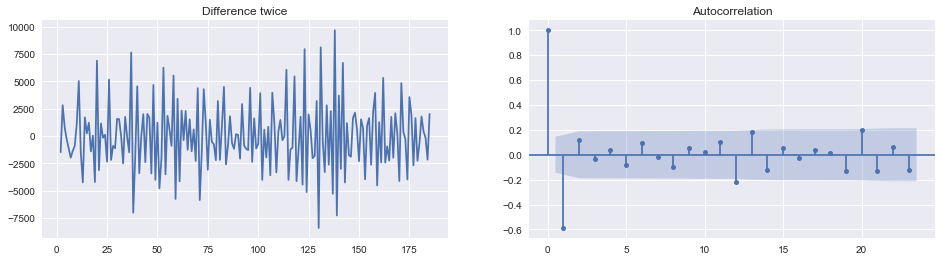

<IPython.core.display.Javascript object>

In [132]:
diff = df.close.diff().diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference twice")
plot_acf(diff, ax=ax2)

We can use the pmdarima package to get the number of differencing.

In [133]:
#!pipenv install --skip-lock pmdarima

from pmdarima.arima.utils import ndiffs

<IPython.core.display.Javascript object>

In [134]:
ndiffs(df.close, test="adf")

1

<IPython.core.display.Javascript object>

#### p

p is the order of the Auto Regressive (AR) term. It refers to the number of lags to be used as predictors. 

We can find out the required number of AR terms by inspecting the Partial Autocorrelation (PACF) plot.

The partial autocorrelation represents the correlation between the series and its lags. 

In [135]:
from statsmodels.graphics.tsaplots import plot_pacf

<IPython.core.display.Javascript object>

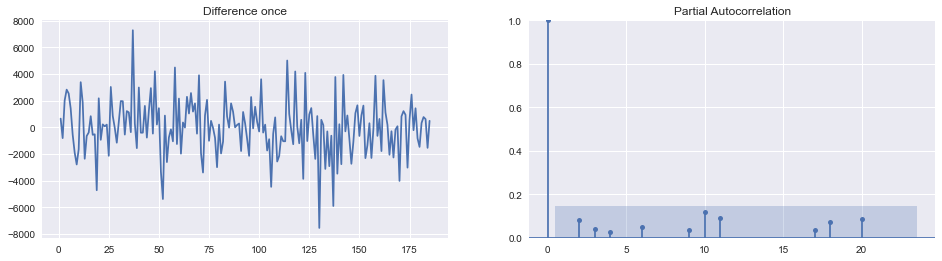

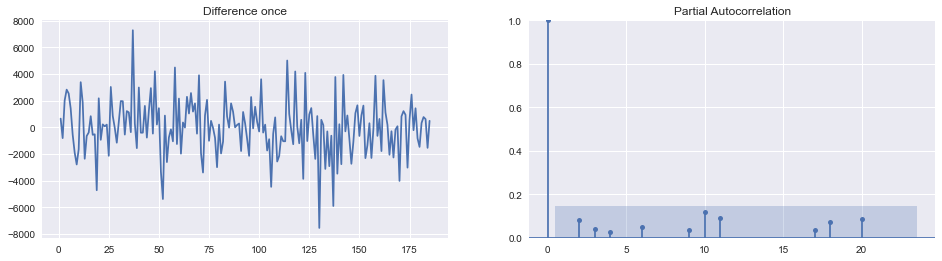

<IPython.core.display.Javascript object>

In [136]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_pacf(diff, ax=ax2)

We can observe that the PACF lag 6 is significant as it's above the significance line.

#### q

q is the order of the Moving Average (MA) term. It refers to the number of lagged forecast errors that should go into the ARIMA Model.

We can look at the ACF plot for the number of MA terms.

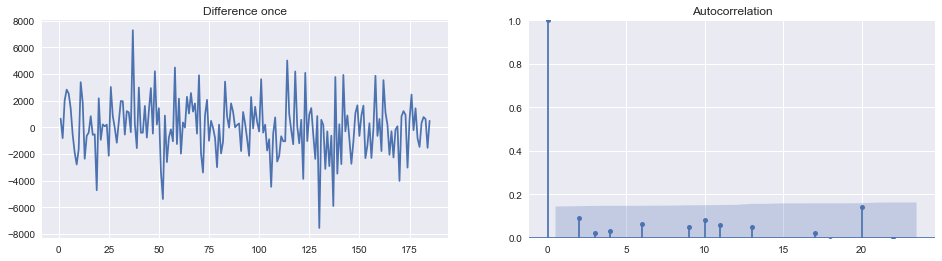

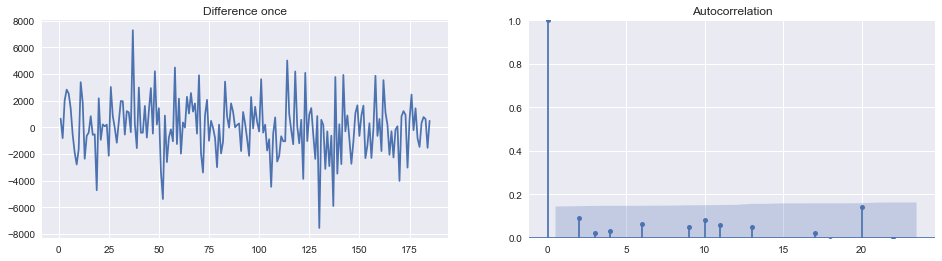

<IPython.core.display.Javascript object>

In [137]:
diff = df.close.diff().dropna()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(diff)
ax1.set_title("Difference once")
ax2.set_ylim(0, 1)
plot_acf(diff, ax=ax2)

#### Fitting the ARIMA model

In [138]:
from statsmodels.tsa.arima_model import ARIMA

# ARIMA Model
model = ARIMA(df.close, order=(10, 1, 2))
result = model.fit(disp=0)

c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 

<IPython.core.display.Javascript object>

In [139]:
print(result.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.close   No. Observations:                  185
Model:                ARIMA(10, 1, 2)   Log Likelihood               -1668.975
Method:                       css-mle   S.D. of innovations           1995.880
Date:                Sat, 06 Nov 2021   AIC                           3365.950
Time:                        18:54:10   BIC                           3411.035
Sample:                             1   HQIC                          3384.222
                                                                              
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              8.2163    139.854      0.059      0.953    -265.893     282.326
ar.L1.D.close     -0.5514      0.088     -6.301      0.000      -0.723      -0.380
ar.L2.D.close     -0.8406      0.097

<IPython.core.display.Javascript object>

(array([1.24515192e-05, 1.66020256e-05, 4.56555703e-05, 1.32816205e-04,
        2.28277852e-04, 1.82622281e-04, 8.71606342e-05, 4.98060767e-05,
        8.30101279e-06, 4.15050639e-06]),
 array([-6282.39807515, -4980.04966411, -3677.70125307, -2375.35284204,
        -1073.004431  ,   229.34398004,  1531.69239107,  2834.04080211,
         4136.38921314,  5438.73762418,  6741.08603522]),
 <BarContainer object of 10 artists>)

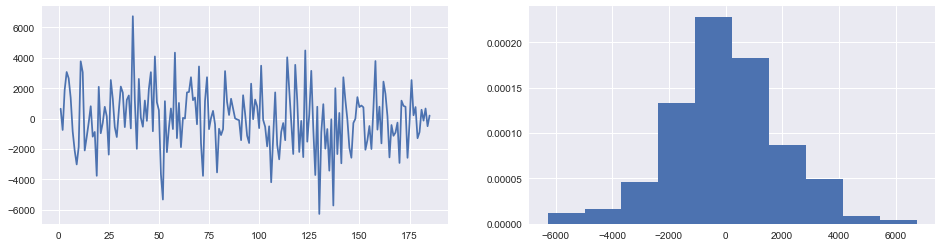

<IPython.core.display.Javascript object>

In [140]:
# Plot residual errors
residuals = pd.DataFrame(result.resid)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 4))

ax1.plot(residuals)
ax2.hist(residuals, density=True)


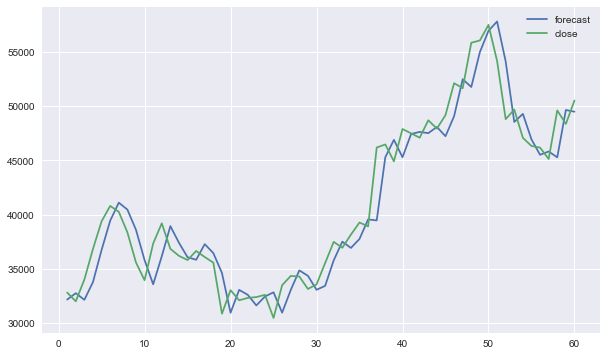

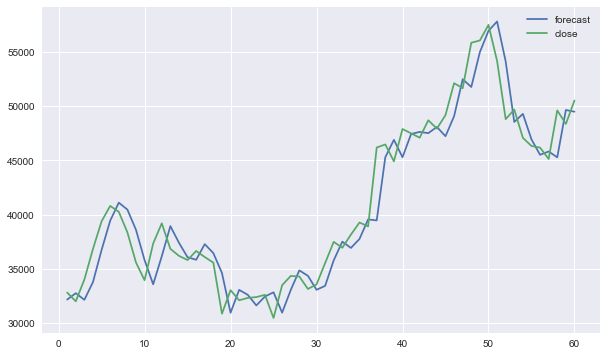

<IPython.core.display.Javascript object>

In [141]:
# Actual vs Fitted
result.plot_predict(
    start=1,
    end=60,
    dynamic=False,
)

### Train test split 

In [142]:
n = int(len(df) * 0.8)
train = df.close[:n]
test = df.close[n:]

<IPython.core.display.Javascript object>

In [143]:
print(len(train))
print(len(test))

148
38


<IPython.core.display.Javascript object>

In [144]:
step = 30

model = ARIMA(train, order=(10, 1, 2))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 

<IPython.core.display.Javascript object>

In [145]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

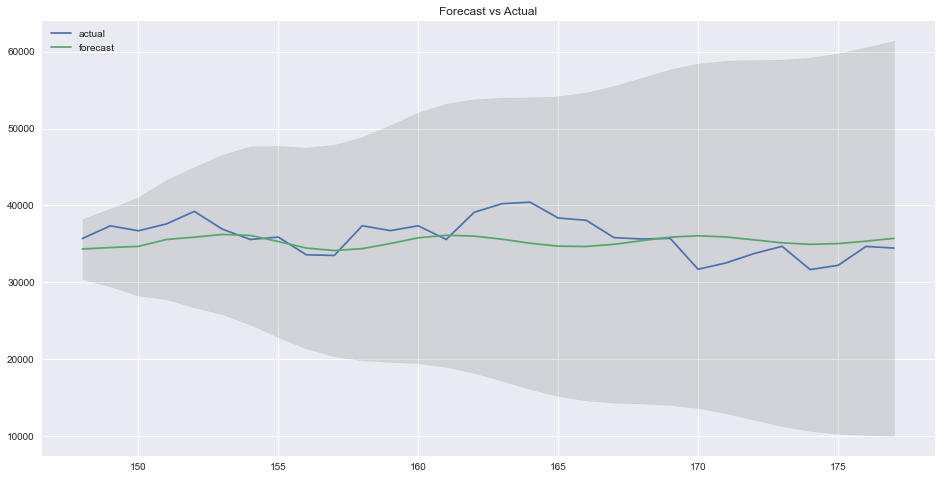

<IPython.core.display.Javascript object>

In [146]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

### Auto ARIMA

The pmdarima package provides an auto_arima method that uses a stepwise approach to search multiple combinations of p,d,q parameters and chooses the best model that has the least AIC.

In [147]:
from pmdarima.arima import auto_arima

<IPython.core.display.Javascript object>

In [148]:
model = auto_arima(
    df.close,
    start_p=1,
    start_q=1,
    test="adf",
    max_p=11,
    max_q=21,
    m=1,  # frequency of series
    d=None,  # determine 'd'
    seasonal=False,  # no seasonality
    trace=True,
    stepwise=True,
)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3362.246, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3359.069, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3360.383, Time=0.02 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3360.434, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3357.077, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.112 seconds


<IPython.core.display.Javascript object>

In [149]:
step = 30

model = ARIMA(train, order=(0, 1, 0))
result = model.fit(disp=0)

# Forecast
fc, se, conf = result.forecast(step)

c:\users\mayur g\appdata\local\programs\python\python38-32\lib\site-packages\statsmodels\tsa\arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)


<IPython.core.display.Javascript object>

In [150]:
fc = pd.Series(fc, index=test[:step].index)
lower = pd.Series(conf[:, 0], index=test[:step].index)
upper = pd.Series(conf[:, 1], index=test[:step].index)

<IPython.core.display.Javascript object>

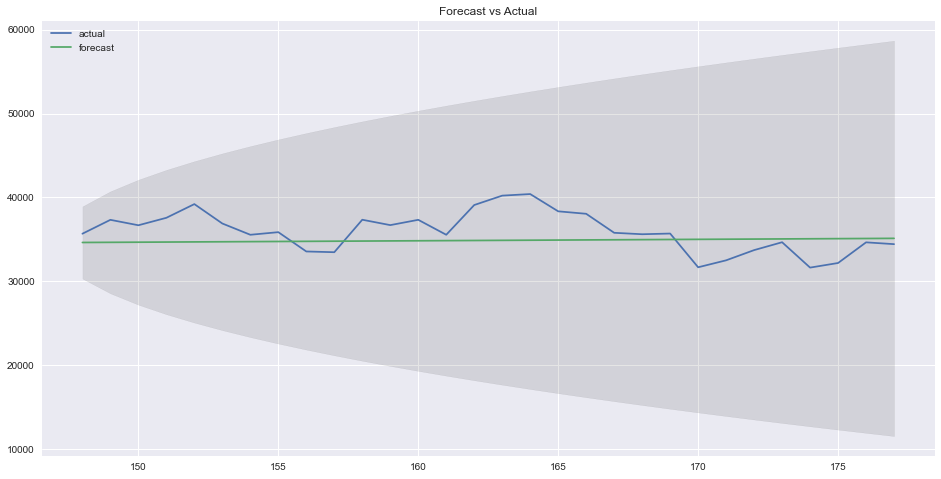

<IPython.core.display.Javascript object>

In [151]:
plt.figure(figsize=(16, 8))
plt.plot(test[:step], label="actual")
plt.plot(fc, label="forecast")
plt.fill_between(lower.index, lower, upper, color="k", alpha=0.1)
plt.title("Forecast vs Actual")
plt.legend(loc="upper left")

# Run Autoarima with exogenous variables
Autoarima is useful as it selects the best values of p,d,q for time series stationarity through an iterative process. Below is brief explaination of p,d,q values
1. p -> is the number of autoregressive terms
2. d -> is the number of nonseasonal differences
3. q -> is the number of lagged forecast errors

In [166]:
# taking polarity as exogenous variables

new_df = pd.read_excel("bitcoin_master_data.xlsx")
df3 = new_df[["polarity"]]
model_autoARIMA = auto_arima(
    df.close,
    start_p=0,
    start_q=0,
    test="adf",  # use adftest to find             optimal 'd'
    max_p=11,
    max_q=20,  # maximum p and q
    m=1,  # frequency of series
    d=None,  # let model determine 'd'
    seasonal=False,  # No Seasonality
    start_P=0,
    D=0,
    trace=True,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True,
    exogenous=df3,
)
print(model_autoARIMA.summary())

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=3360.895, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=3362.236, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=3362.285, Time=0.04 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=3358.902, Time=0.04 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=3364.101, Time=0.05 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.179 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  186
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1677.451
Date:                Sat, 06 Nov 2021   AIC                           3358.902
Time:                        19:01:08   BIC                           3365.342
Sample:                             0   HQIC                          3361.512
                                - 186                                       

<IPython.core.display.Javascript object>

# The best model is ARIMA(0,1,0)


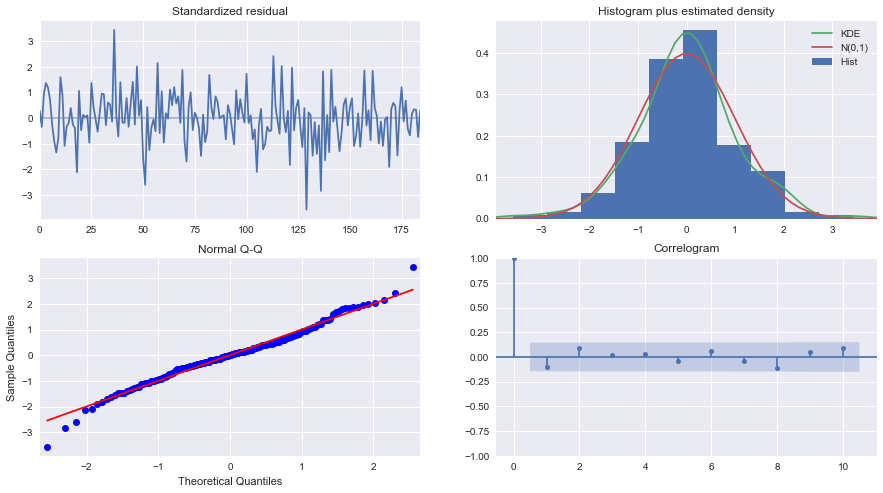

<IPython.core.display.Javascript object>

In [167]:
model_autoARIMA.plot_diagnostics(figsize=(15, 8))
plt.show()

# Based on the above diagnostic metrics we see the model is accurate
* Residual does not have specific trend
* Histogram is near normal¶

In [168]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

model = SARIMAX(
    df.close,
    exog=df3,
    order=(0, 1, 0),
    enforce_invertibility=False,
    enforce_stationarity=False,
)

<IPython.core.display.Javascript object>

In [169]:
results = model.fit()
forecast_1 = results.forecast(steps=len(new_df.Close), exog=df3)

<IPython.core.display.Javascript object>

In [170]:
print(forecast_1)

186    34376.731876
187    34422.817664
188    34337.560273
189    34391.556064
190    34366.023908
           ...     
367    34335.400168
368    34392.192664
369    34343.531484
370    34351.905912
371    34235.193450
Name: predicted_mean, Length: 186, dtype: float64


<IPython.core.display.Javascript object>

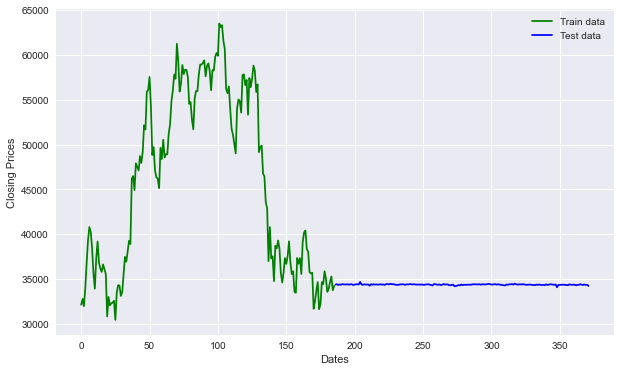

<IPython.core.display.Javascript object>

In [171]:
train_data = new_df.Close
test_data = forecast_1
plt.figure(figsize=(10, 6))
plt.grid(True)
plt.xlabel("Dates")
plt.ylabel("Closing Prices")
plt.plot(train_data, "green", label="Train data")
plt.plot(test_data, "blue", label="Test data")
plt.legend()

# The forecast is linear line and not as good as expected,more work is required to get better forecast,will explore more .